In [1]:
# %pip install numpy pandas librosa scikit-learn catboost matplotlib

import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:

DATA_DIR = "/Users/dmwelch/Development/NYU/MIR/finalProj/Data/genres_original"

def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=30)
    features = np.array([])

    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    mfccs_mean = mfccs.mean(axis=1)
    features = np.hstack((features, mfccs_mean))

    # Chromagram
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = chroma.mean(axis=1)
    features = np.hstack((features, chroma_mean))

    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast_mean = contrast.mean(axis=1)
    features = np.hstack((features, contrast_mean))

    # Tonnetz
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    tonnetz_mean = tonnetz.mean(axis=1)
    features = np.hstack((features, tonnetz_mean))

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = zcr.mean()
    features = np.hstack((features, zcr_mean))

    # Spectral Roll-off
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rolloff_mean = rolloff.mean()
    features = np.hstack((features, rolloff_mean))

    return features

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
# dataset = []

# for genre in genres:
#     genre_dir = os.path.join(DATA_DIR, genre)
#     for filename in os.listdir(genre_dir):
#         if filename.endswith('.wav'):
#             file_path = os.path.join(genre_dir, filename)
#             features = extract_features(file_path)
#             dataset.append([features, genre])


# # Convert to DataFrame
# df = pd.DataFrame(dataset, columns=['features', 'label'])

import pickle

# # Save the DataFrame
# with open('dataset.pkl', 'wb') as f:
#     pickle.dump(df, f)

# Load the DataFrame
with open('dataset.pkl', 'rb') as f:
    df = pickle.load(f)

X = np.array(df['features'].tolist())
y = np.array(df['label'].tolist())

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

ada_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train, y_train)

cat_clf = CatBoostClassifier(
    iterations=100,
    learning_rate=0.5,
    depth=6,
    loss_function='MultiClass',
    verbose=False,
    random_state=42
)
cat_clf.fit(X_train, y_train)

y_pred_ada = ada_clf.predict(X_test)
print("AdaBoost Classification Report:")
print(classification_report(y_test, y_pred_ada, target_names=le.classes_))

y_pred_cat = cat_clf.predict(X_test)
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat, target_names=le.classes_))

/Users/dmwelch/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost Classification Report:
              precision    recall  f1-score   support

       blues       0.31      0.25      0.28        20
   classical       0.89      0.40      0.55        20
     country       0.42      0.50      0.45        20
       disco       0.40      0.20      0.27        20
      hiphop       0.27      0.45      0.34        20
        jazz       0.32      0.50      0.39        20
       metal       0.85      0.55      0.67        20
         pop       0.42      0.55      0.48        20
      reggae       0.32      0.30      0.31        20
        rock       0.16      0.15      0.15        20

    accuracy                           0.38       200
   macro avg       0.44      0.38      0.39       200
weighted avg       0.44      0.39      0.39       200

CatBoost Classification Report:
              precision    recall  f1-score   support

       blues       0.69      0.55      0.61        20
   classical       0.85      0.85      0.85        20
     country  

In [3]:
# AdaBoost Report
y_pred_ada = ada_clf.predict(X_test)
print("AdaBoost Classification Report:")
print(classification_report(y_test, y_pred_ada, target_names=le.classes_))

# CatBoost Report
y_pred_cat = cat_clf.predict(X_test)
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat, target_names=le.classes_))

AdaBoost Classification Report:
              precision    recall  f1-score   support

       blues       0.31      0.25      0.28        20
   classical       0.89      0.40      0.55        20
     country       0.42      0.50      0.45        20
       disco       0.40      0.20      0.27        20
      hiphop       0.27      0.45      0.34        20
        jazz       0.32      0.50      0.39        20
       metal       0.85      0.55      0.67        20
         pop       0.42      0.55      0.48        20
      reggae       0.32      0.30      0.31        20
        rock       0.16      0.15      0.15        20

    accuracy                           0.38       200
   macro avg       0.44      0.38      0.39       200
weighted avg       0.44      0.39      0.39       200

CatBoost Classification Report:
              precision    recall  f1-score   support

       blues       0.69      0.55      0.61        20
   classical       0.85      0.85      0.85        20
     country  

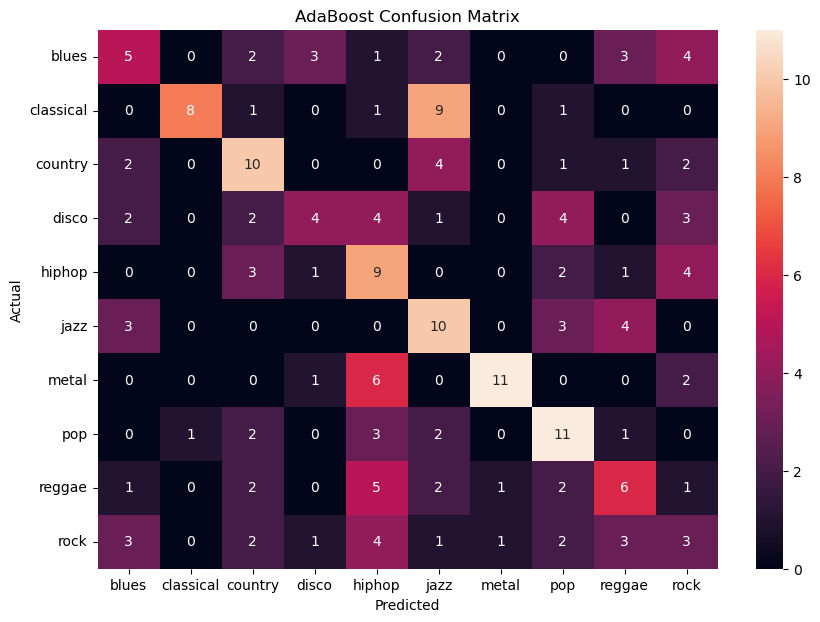

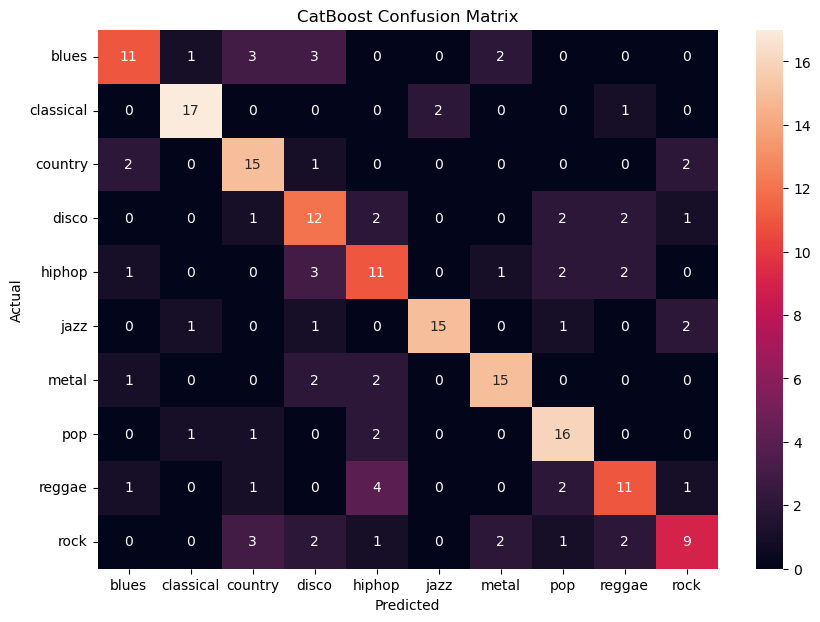

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# AdaBoost Confusion Matrix
cm_ada = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(10,7))
sns.heatmap(cm_ada, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('AdaBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# CatBoost Confusion Matrix
cm_cat = confusion_matrix(y_test, y_pred_cat)
plt.figure(figsize=(10,7))
sns.heatmap(cm_cat, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('CatBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()